In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pmdarima.arima import auto_arima
from datetime import datetime
import matplotlib.pyplot as plt
import tsfresh
from pmdarima.arima import ADFTest
from tsfresh import extract_features
from statsmodels.tsa.arima.model import ARIMA

In [2]:
values = read_csv("../../Electric_Production.csv")

In [3]:
values.head(13)

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
5,6/1/1985,58.0904
6,7/1/1985,62.6202
7,8/1/1985,63.2485
8,9/1/1985,60.5846
9,10/1/1985,56.3154


In [4]:

values = values.rename(columns={'DATE': 'Time'})
values = values.rename(columns={'IPG2211A2N': 'Data'})
values['Time'] = pd.to_datetime(
    values['Time'], errors='coerce')

In [5]:
freq = pd.infer_freq(values["Time"])

In [6]:
# end_date = pd.to_datetime(x) + pd.DateOffset(months=10)
# print(end_date)

NameError: name 'x' is not defined

In [7]:
values.set_index('Time', inplace=True)

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
    values, test_size=0.2, shuffle=False)

In [9]:
model = ARIMA( train, exog=None, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), 
              trend=None, enforce_stationarity=False, enforce_invertibility=True, 
              concentrate_scale=False, trend_offset=1, dates=None, freq=None, 
              missing='none', validate_specification=False)
model_fit = model.fit() 
# model_fit.summary()

c:\Users\haman\anaconda3\envs\doan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\haman\anaconda3\envs\doan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\haman\anaconda3\envs\doan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [10]:
train.tail(2)

,Data
Time,
2011-04-01,89.3583
2011-05-01,90.0698


In [11]:
x = values.index[train.shape[0]]
print(x)

2011-06-01 00:00:00


In [12]:
n_periods = test.shape[0] + 12

In [13]:
index_future_dates = pd.date_range(
    start=x, periods=n_periods, freq=freq)

index_future_dates

DatetimeIndex(['2011-06-01', '2011-07-01', '2011-08-01', '2011-09-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
      

In [14]:
predicted = model_fit.forecast(n_periods)

In [15]:
prediction = pd.DataFrame(predicted, index=index_future_dates)
prediction.columns = ['predicted_values']
prediction.reset_index(inplace=True)

In [16]:
prediction=prediction.tail(12)
print(prediction)

        index  predicted_values
80 2018-02-01        114.316003
81 2018-03-01        105.800263
82 2018-04-01         95.679632
83 2018-05-01         97.063235
84 2018-06-01        108.328434
85 2018-07-01        116.203879
86 2018-08-01        117.052545
87 2018-09-01        105.606682
88 2018-10-01         97.664908
89 2018-11-01         99.776108
90 2018-12-01        117.493540
91 2019-01-01        124.109426


In [17]:
prediction.columns.value_counts

<bound method IndexOpsMixin.value_counts of Index(['index', 'predicted_values'], dtype='object')>

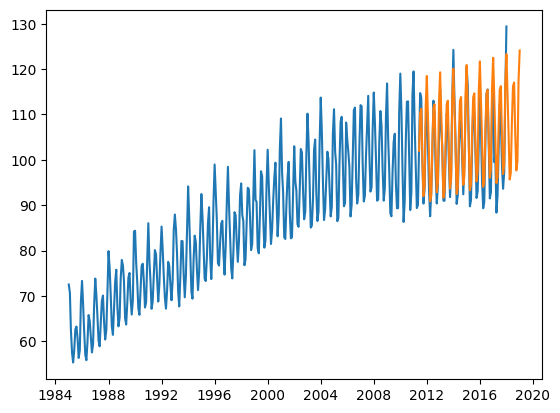

In [18]:
plt.plot(values.index,values['Data'])
plt.plot(index_future_dates,predicted)